In [128]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
import seaborn as sns 
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import nltk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


tqdm.pandas()

In [130]:
splits = {'train': 'data/train-00000-of-00001-9df3a936e1f63191.parquet', 'test': 'data/test-00000-of-00001-af2a9f454ad1b8a3.parquet'}
df_train = pd.read_parquet("hf://datasets/neural-bridge/rag-dataset-12000/" + splits["train"])

In [131]:
df_test = pd.read_parquet("hf://datasets/neural-bridge/rag-dataset-12000/" + splits["test"])

In [132]:
df = pd.concat([df_train, df_test]).reset_index(drop = True)

In [133]:
df.shape

(12000, 3)

In [134]:
df.head()

,context,question,answer
0,Caption: Tasmanian berry grower Nic Hansen sho...,What is the Berry Export Summary 2028 and what...,The Berry Export Summary 2028 is a dedicated e...
1,RWSN Collaborations\nSouthern Africa Self-supp...,What are some of the benefits reported from ha...,Benefits reported from having access to Self-s...
2,All Android applications categories\nDescripti...,What are the unique features of the Coolands f...,The unique features of the Coolands for Twitte...
3,"How unequal is India? The question is simple, ...",What is the main difference between the Nation...,The main difference between the NSS and the IH...
4,Gunnar Nelson took his time on the feet agains...,How did Gunnar Nelson win the fight against Za...,Gunnar Nelson won the fight against Zak Cummin...


# Количество пропусков в данных

In [136]:
df.isna().sum()

context     0
question    3
answer      3
dtype: int64

In [137]:
df = df.fillna("")

In [138]:
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

C:\Users\ga232\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [139]:

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').to("cuda")

In [140]:
df['context_tokens'] = df['context'].progress_apply(lambda x: tokenizer([x], truncation = False)["input_ids"][0])
df['question_tokens'] = df['question'].progress_apply(lambda x: tokenizer([x], truncation = False)["input_ids"][0])
df['answer_tokens'] = df['answer'].progress_apply(lambda x: tokenizer([x], truncation = False)["input_ids"][0])

  0%|          | 0/12000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (695 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

# Гистограмма токенизированных контекстов/ответов/вопросов

## Гистограмма контекстов
Видно, что тексты будут сильно обрубаться токенизаторов, что в последствии может сказаться на точность RAG.
Вероятно придется использовать эмбедеры с большим окном контекста, или уже нарезать имеющиеся чанки на более мелкие части.


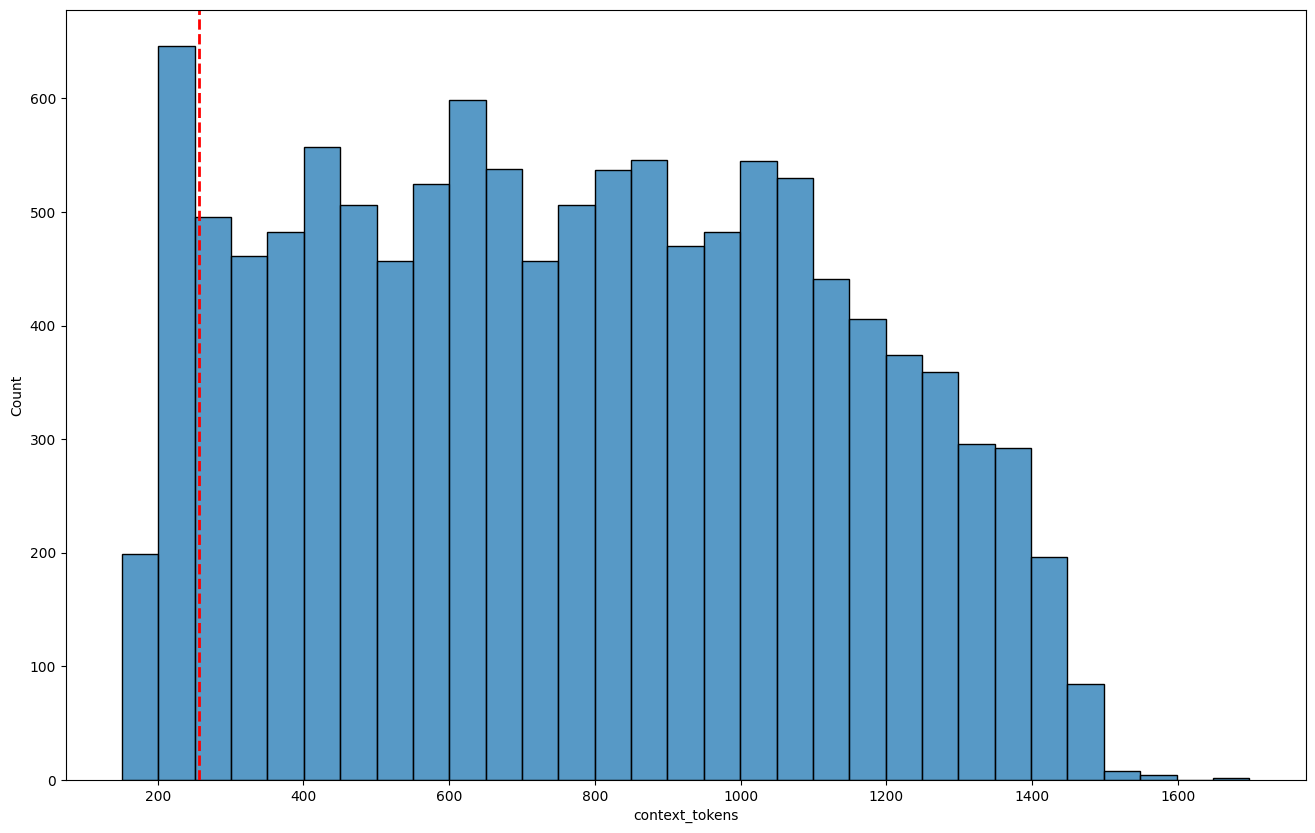

In [143]:


plt.figure(figsize = (16,10))
sns.histplot(df['context_tokens'].apply(len))
plt.axvline(x=model[0].max_seq_length, color='r', linestyle='--', linewidth=2)


plt.show()

## Гистограмма Вопросов
Вопросы спокойно будут эмбеддится base-line моделью. Тут должно быть все хорошо.

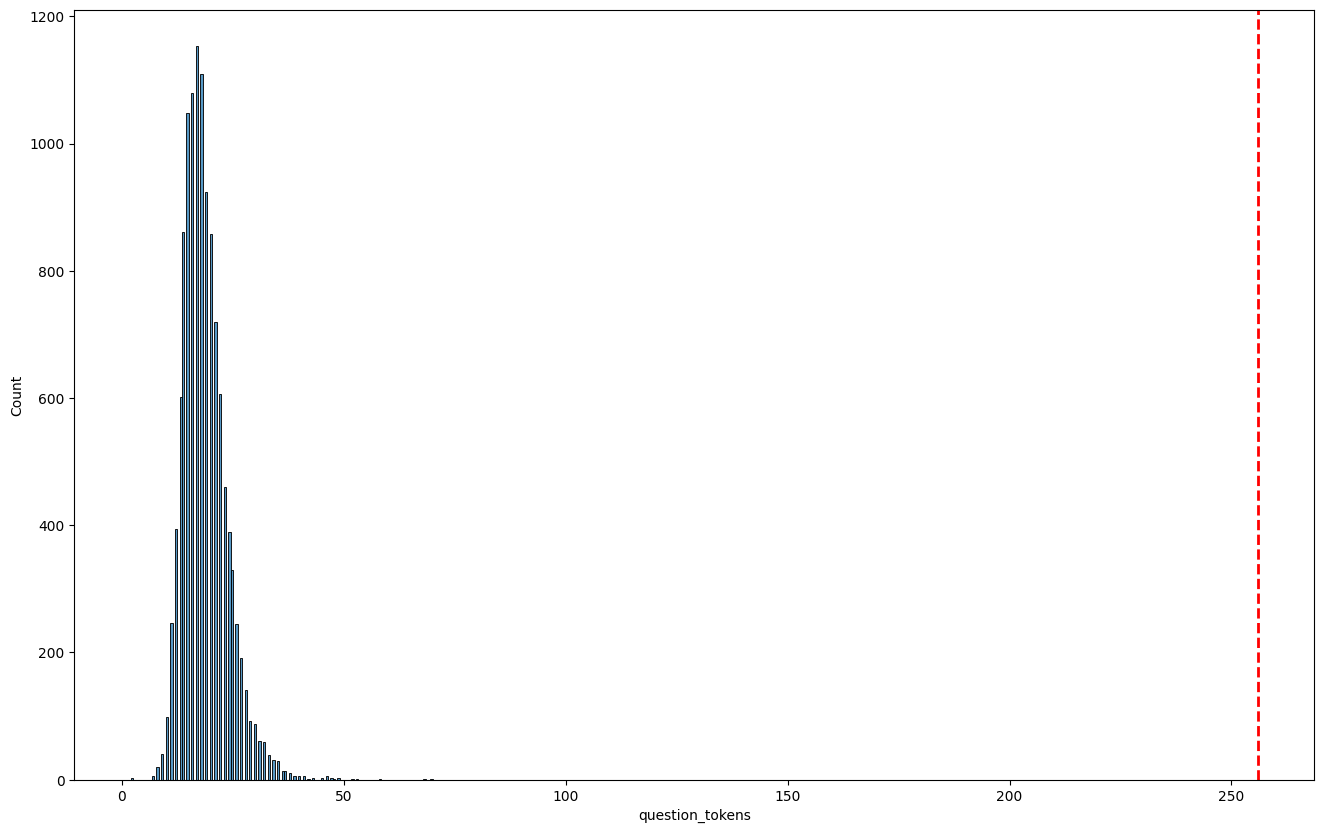

In [145]:
plt.figure(figsize = (16,10))

sns.histplot(df['question_tokens'].apply(len))
plt.axvline(x=model[0].max_seq_length, color='r', linestyle='--', linewidth=2)


plt.show()

## Гистограмма Ответов
Ответов спокойно будут эмбеддится base-line моделью. Тут должно быть все хорошо.

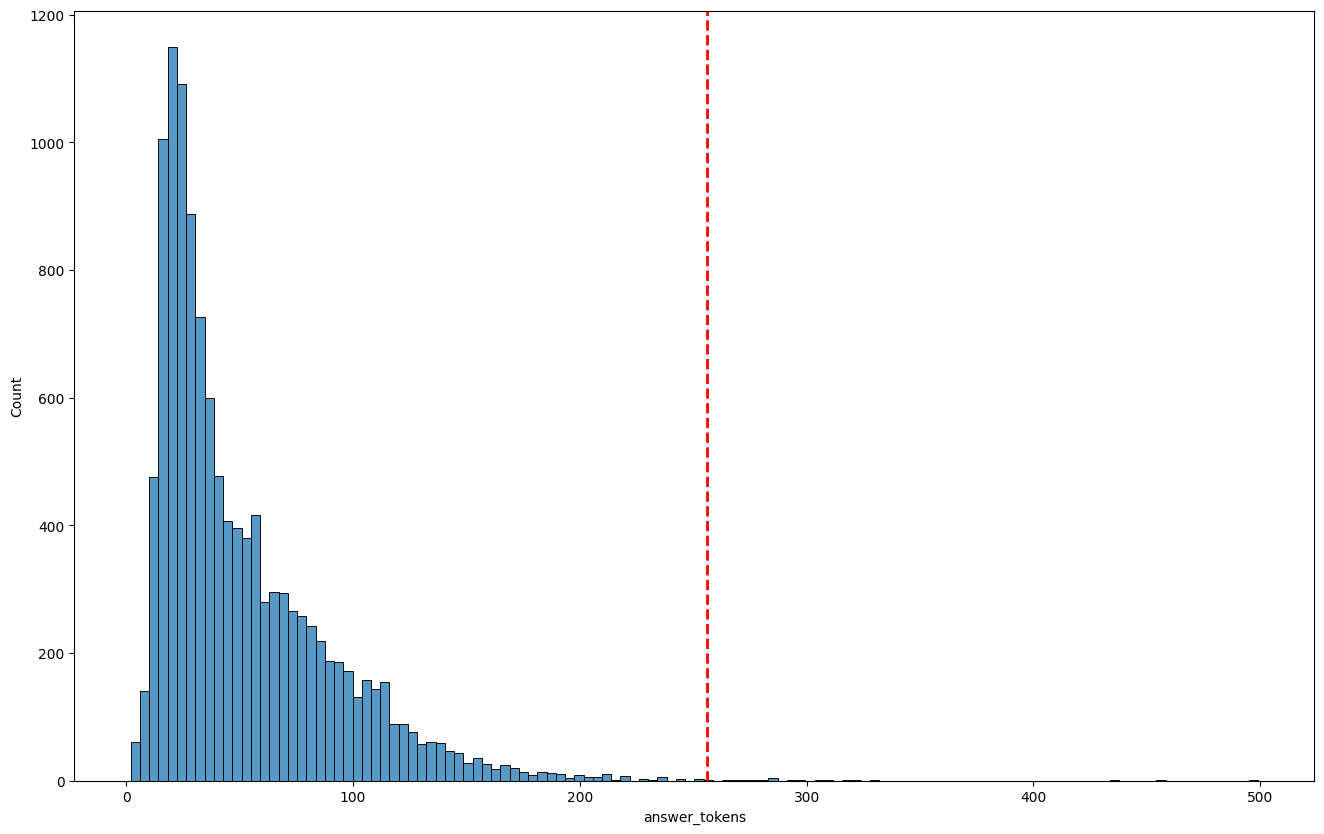

In [147]:
plt.figure(figsize = (16,10))
sns.histplot(df['answer_tokens'].apply(len))
plt.axvline(x=model[0].max_seq_length, color='r', linestyle='--', linewidth=2)


plt.show()

# Облака точек
Перед построением облака точек будет произведена очистка от стоп слов, в противном случае в визуализацию попадут только они)

## Облако точек для контекста

In [150]:
df1 = pd.concat([df_train, df_test]).reset_index(drop = True).fillna("")

In [151]:
import re 
all_text = ''.join(df1['context'].astype(str)).lower()

all_text = re.sub(r'[^\w\s]', '', all_text)

all_text = re.sub(r'\d+','', all_text)


stopWords = set(stopwords.words('english'))
words = word_tokenize(all_text)


wordsFiltered = [w for w in words if w not in stopWords]
words_count = Counter(wordsFiltered)


In [152]:
most_popular = words_count.most_common(100)

text = ""
for word,n in tqdm(most_popular) :
    text+= n*(word + " ")
    

  0%|          | 0/100 [00:00<?, ?it/s]

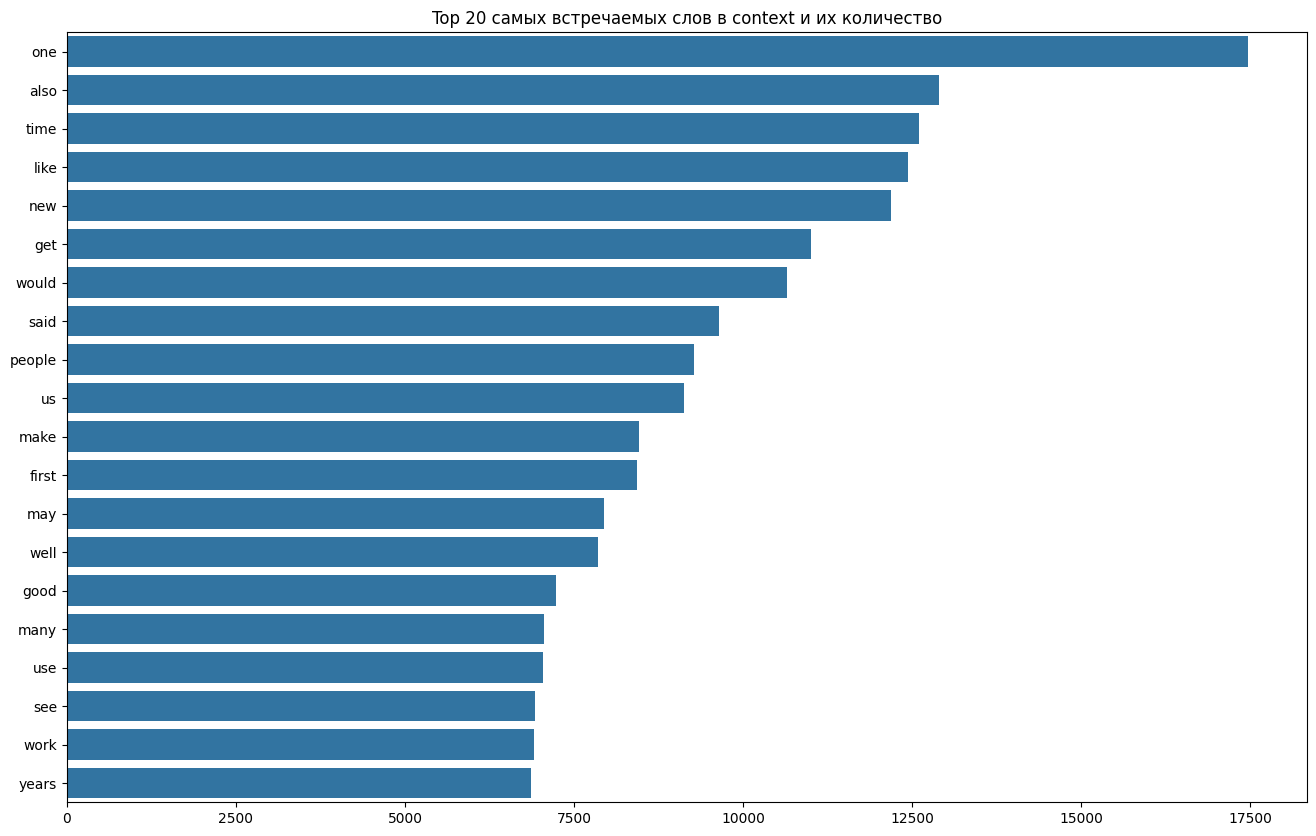

In [153]:

x,y = [],[]
for a,b in most_popular[:20]:
    x.append(a)
    y.append(b)

plt.figure(figsize = (16,10))
plt.title("Top 20 самых встречаемых слов в context и их количество")
sns.barplot(x=y,y=x)
plt.show()

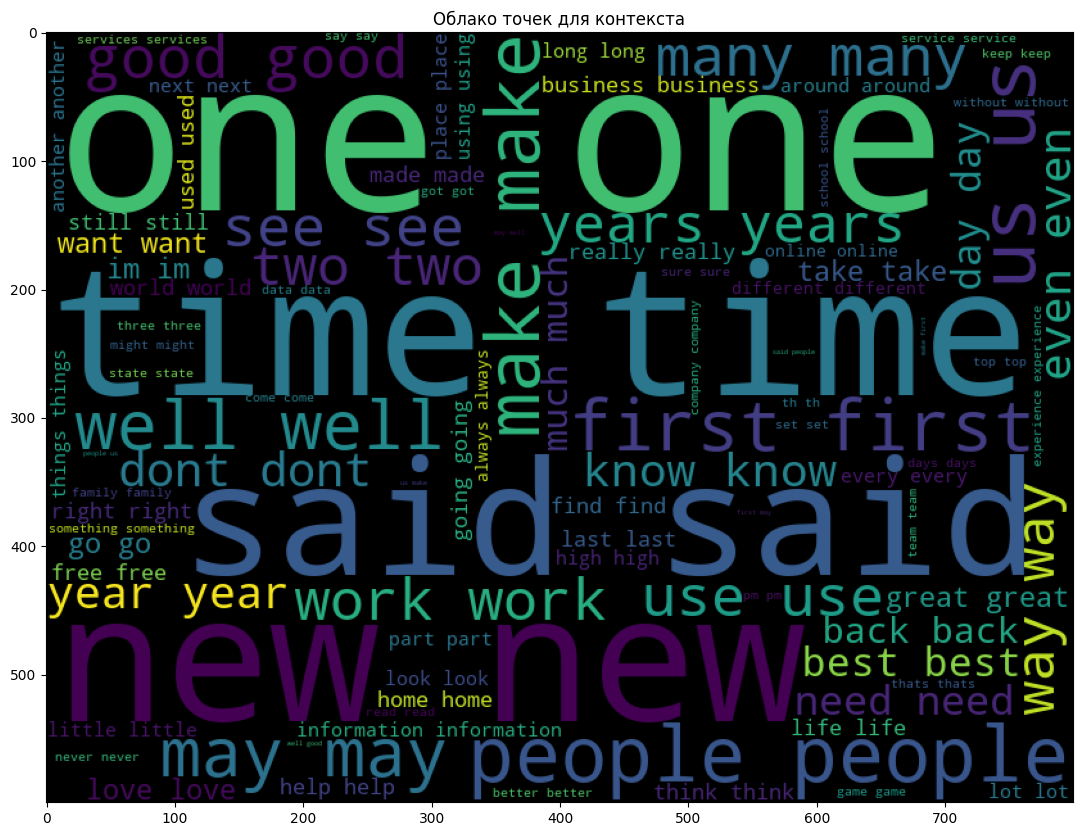

In [154]:
wcloud = WordCloud(width = 800, height = 600, max_words = 100).generate(text)


plt.figure(figsize = (16,10))
plt.title("Облако точек для контекста")
plt.imshow(wcloud)
plt.show()

## Облако точек для вопросов

In [156]:
all_text = ''.join(df1['question'].astype(str)).lower()

all_text = re.sub(r'[^\w\s]', '', all_text)

all_text = re.sub(r'\d+','', all_text)


stopWords = set(stopwords.words('english'))
words = word_tokenize(all_text)


wordsFiltered = [w for w in words if w not in stopWords]
words_count = Counter(wordsFiltered)

In [157]:
most_popular = words_count.most_common(100)

text = ""
for word,n in tqdm(most_popular) :
    text+= n*(word + " ")

  0%|          | 0/100 [00:00<?, ?it/s]

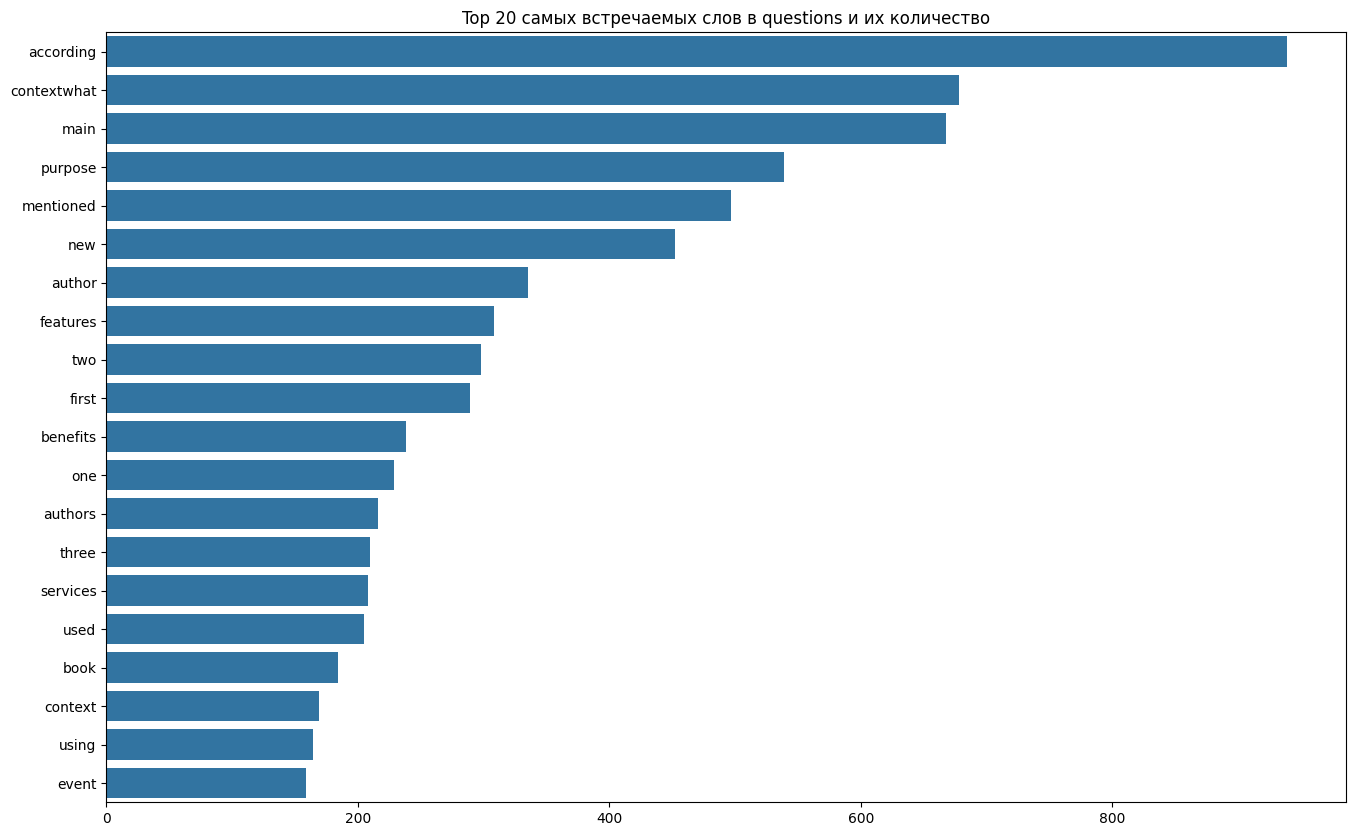

In [159]:

x,y = [],[]
for a,b in most_popular[:20]:
    x.append(a)
    y.append(b)

plt.figure(figsize = (16,10))
plt.title("Top 20 самых встречаемых слов в questions и их количество")
sns.barplot(x=y,y=x)
plt.show()

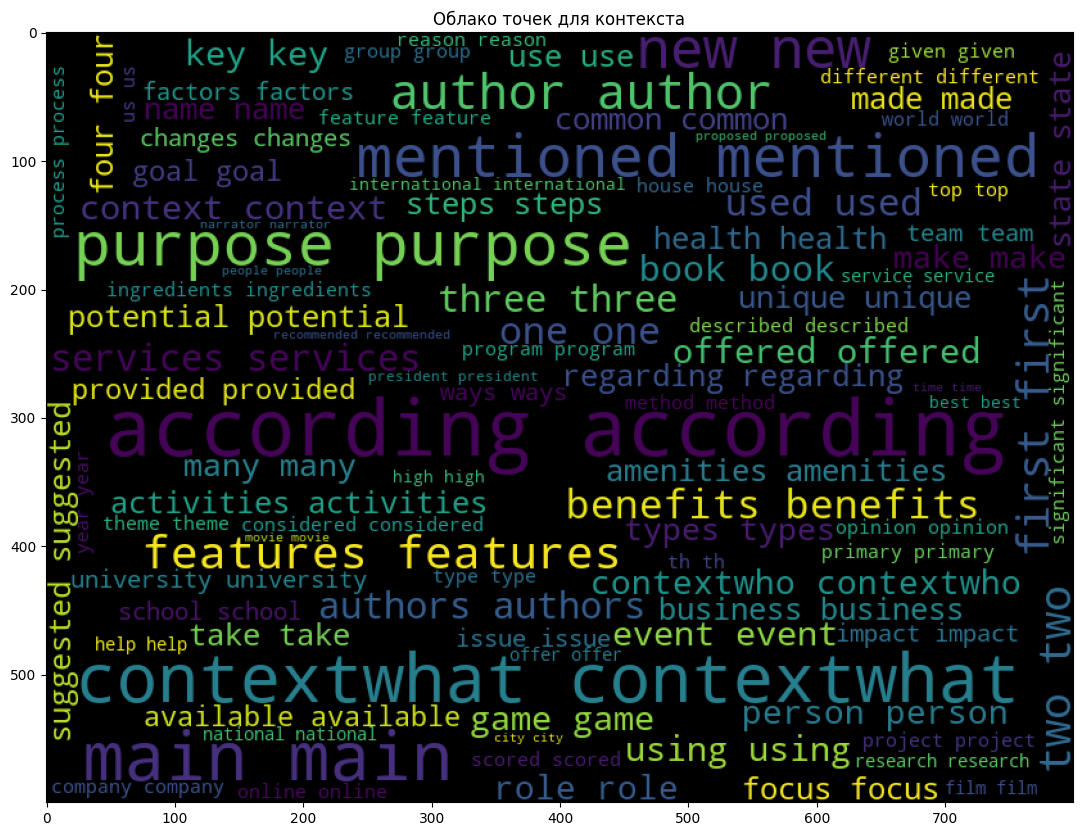

In [160]:
wcloud = WordCloud(width = 800, height = 600, max_words = 100).generate(text)


plt.figure(figsize = (16,10))
plt.title("Облако точек для контекста")
plt.imshow(wcloud)
plt.show()

## Облако точек для ответов

In [162]:
all_text = ''.join(df1['answer'].astype(str)).lower()

all_text = re.sub(r'[^\w\s]', '', all_text)

all_text = re.sub(r'\d+','', all_text)


stopWords = set(stopwords.words('english'))
words = word_tokenize(all_text)


wordsFiltered = [w for w in words if w not in stopWords]
words_count = Counter(wordsFiltered)

In [163]:
most_popular = words_count.most_common(100)

text = ""
for word,n in tqdm(most_popular) :
    text+= n*(word + " ")

  0%|          | 0/100 [00:00<?, ?it/s]

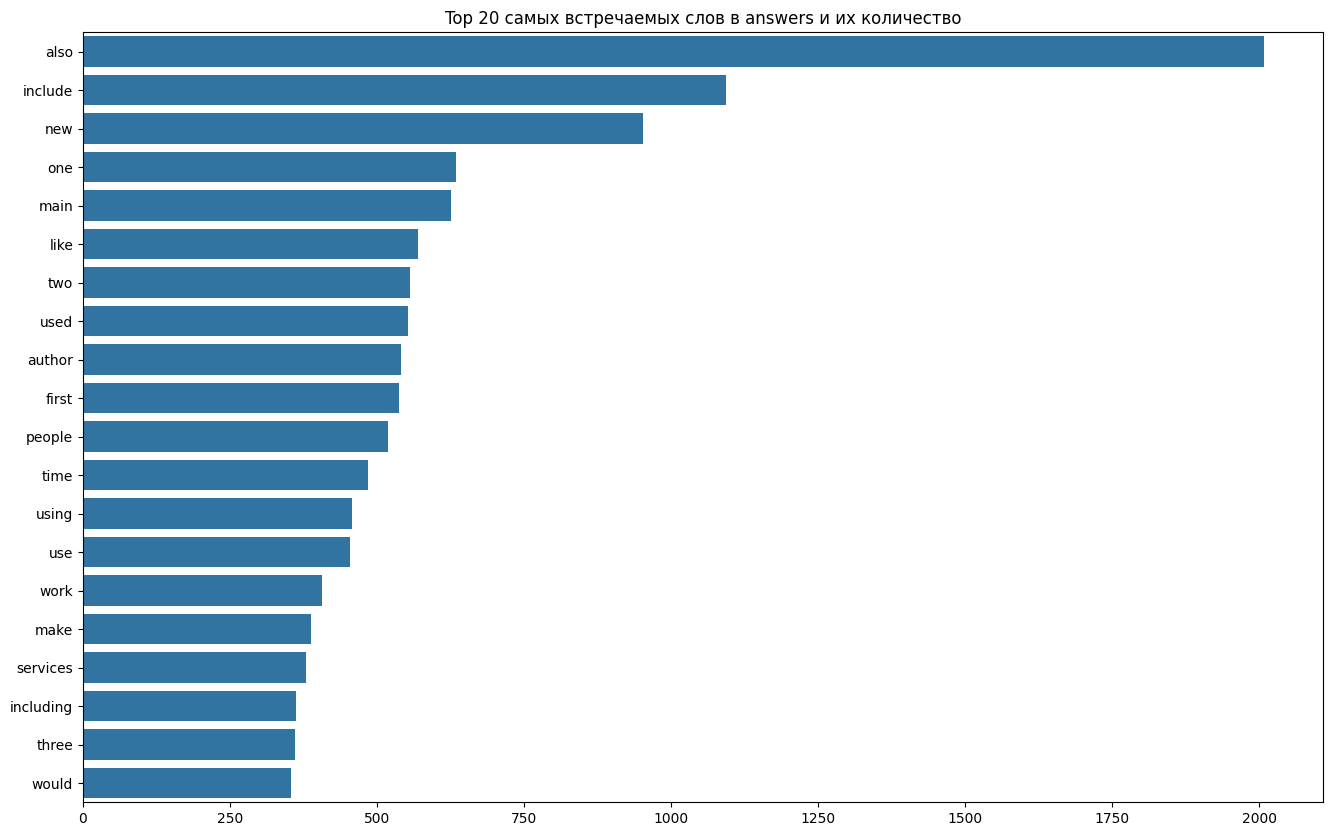

In [164]:

x,y = [],[]
for a,b in most_popular[:20]:
    x.append(a)
    y.append(b)

plt.figure(figsize = (16,10))
plt.title("Top 20 самых встречаемых слов в answers и их количество")
sns.barplot(x=y,y=x)
plt.show()

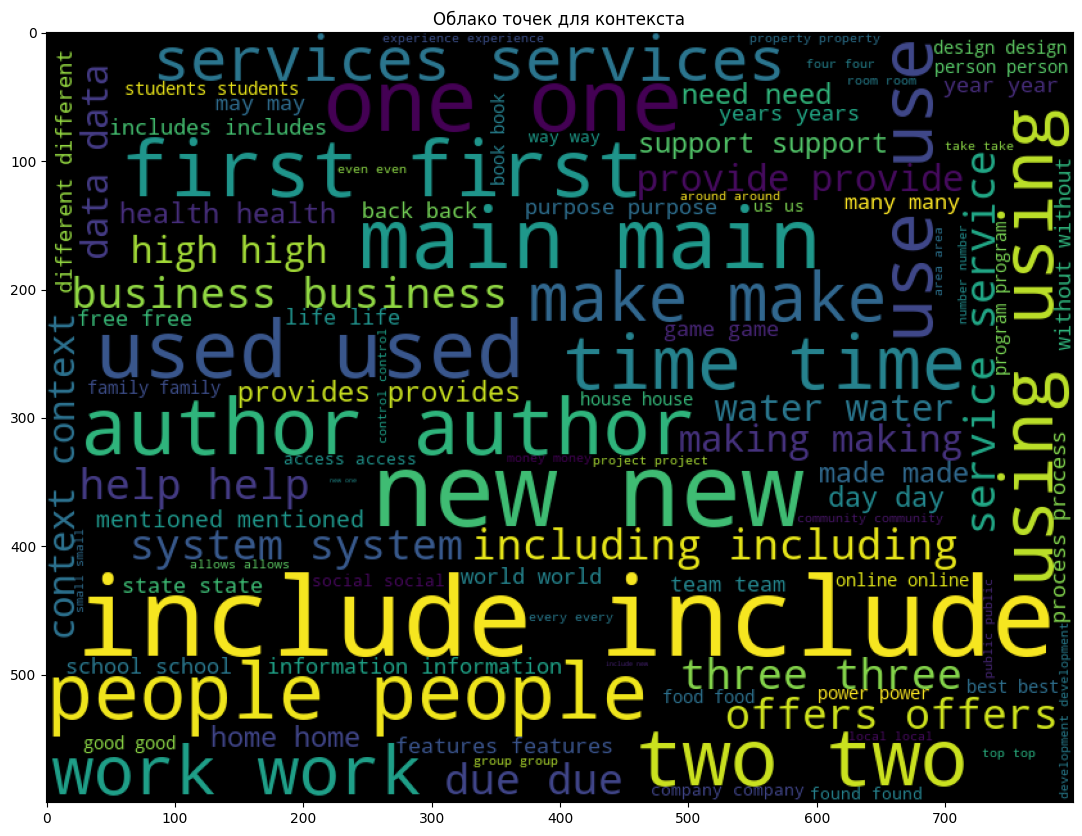

In [165]:
wcloud = WordCloud(width = 800, height = 600, max_words = 100).generate(text)


plt.figure(figsize = (16,10))
plt.title("Облако точек для контекста")
plt.imshow(wcloud)
plt.show()

In [173]:
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
)

# Визуализация эмбеддингов через T-SNE

## Визуализация эмбеддингов контекста

In [12]:
embeddings = df['context'].progress_apply(lambda x: model.encode(x,device = 'cuda')).values

  0%|          | 0/12000 [00:00<?, ?it/s]

C:\Users\ga232\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


C:\Users\ga232\AppData\Local\Temp\ipykernel_5496\3373892297.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


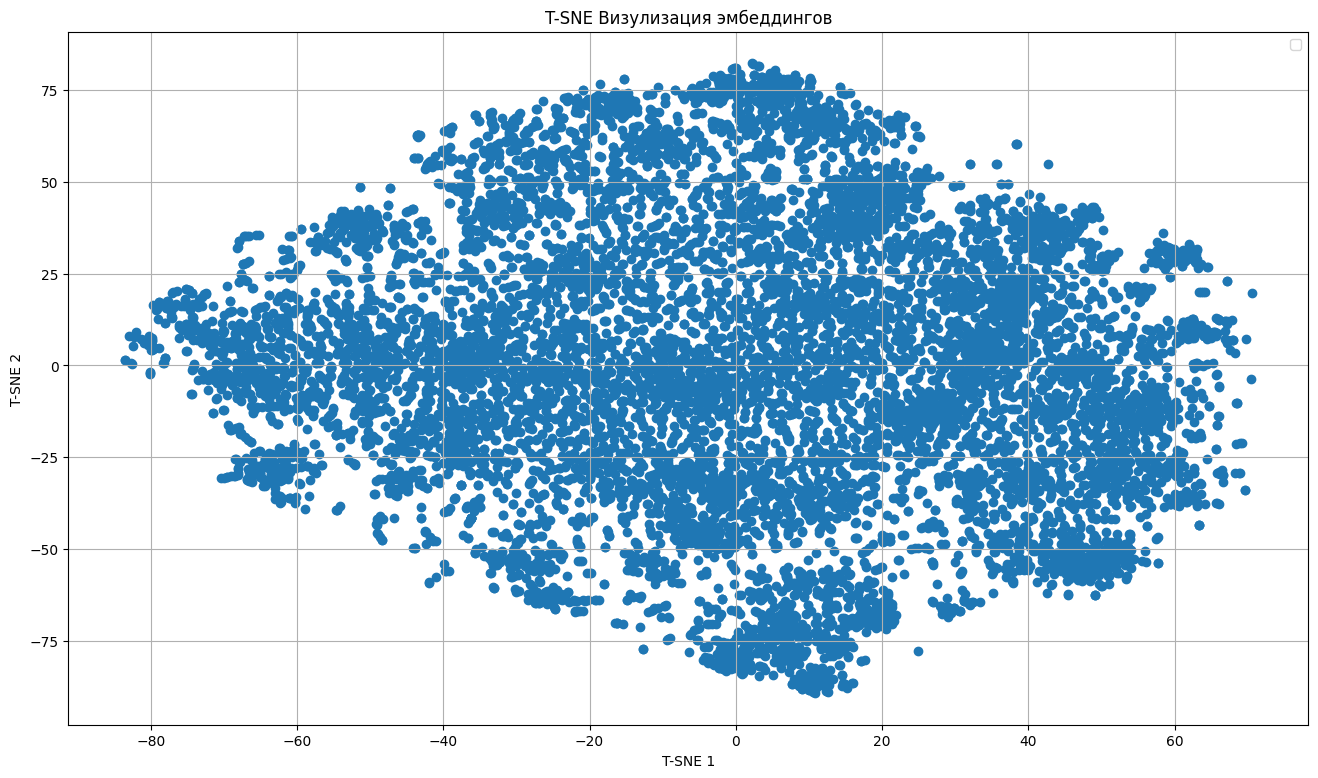

In [21]:
# Применяем T-SNE для снижения размерности до 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(np.array([i for i in embeddings]))


plt.figure(figsize=(16, 9))



plt.scatter(embeddings_2d[:,0],
            embeddings_2d[:,1])

plt.title('T-SNE Визулизация эмбеддингов')
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.legend()
plt.grid(True)
plt.show()

## Визуализация эмбеддингов вопроса

In [22]:
embedings = df['question'].progress_apply(lambda x: model.encode(x,device = 'cuda')).values

  0%|          | 0/12000 [00:00<?, ?it/s]

C:\Users\ga232\AppData\Local\Temp\ipykernel_5496\2010840070.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


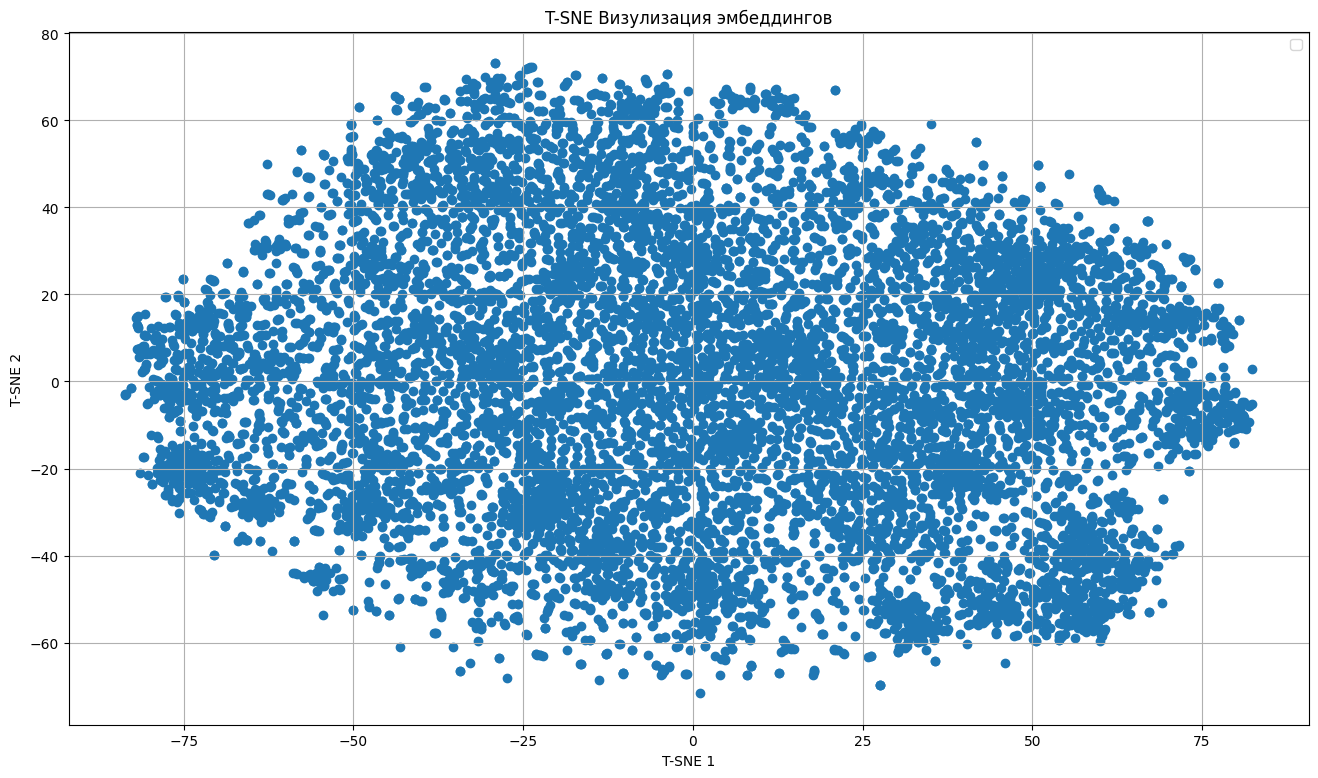

In [28]:
# Применяем T-SNE для снижения размерности до 2D
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(np.array([i for i in embedings]))


plt.figure(figsize=(16, 9))



plt.scatter(embeddings_2d[:,0],
            embeddings_2d[:,1])

plt.title('T-SNE Визулизация эмбеддингов')
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.legend()
plt.grid(True)
plt.show()

## Визуализация эмбеддингов ответа

In [34]:
embedings = df['answer'].progress_apply(lambda x: model.encode(x,device = 'cuda')).values

  0%|          | 0/12000 [00:00<?, ?it/s]

C:\Users\ga232\AppData\Local\Temp\ipykernel_5496\2010840070.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


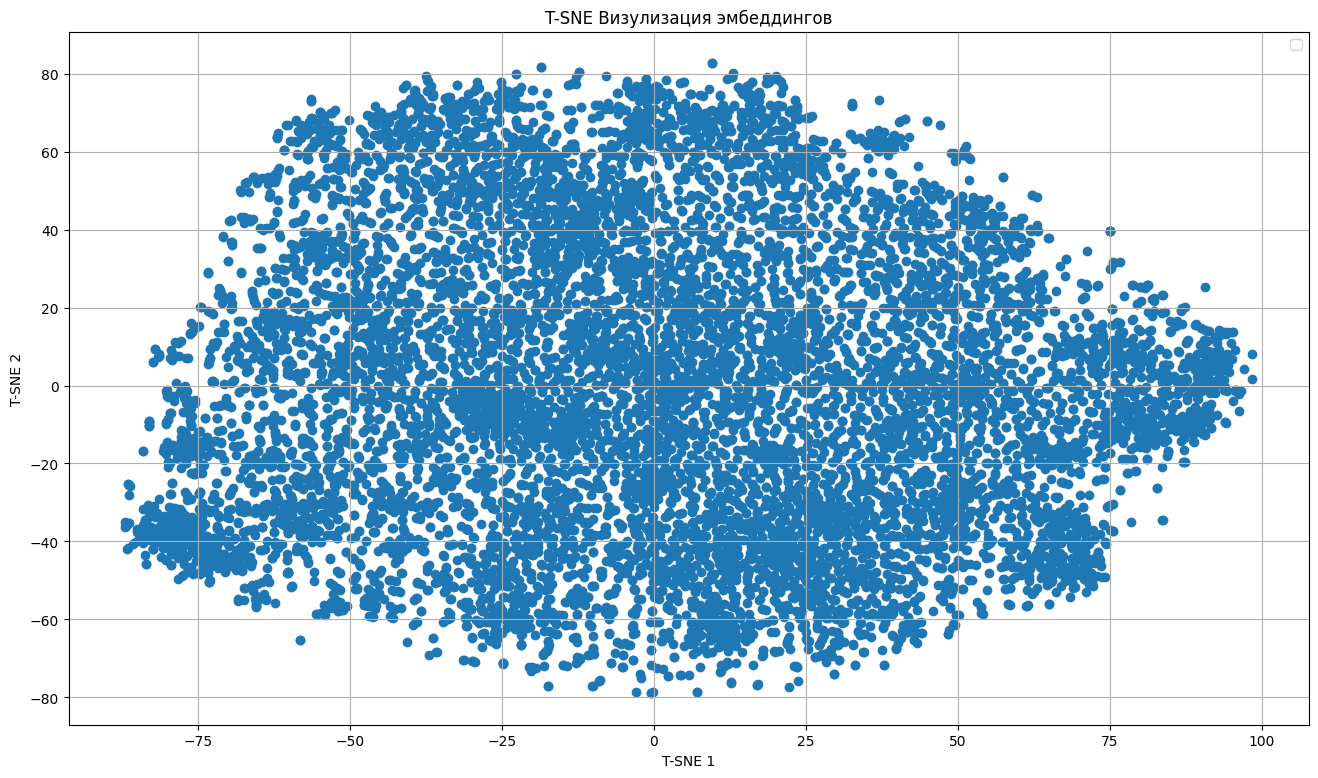

In [35]:

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(np.array([i for i in embedings]))


plt.figure(figsize=(16, 9))



plt.scatter(embeddings_2d[:,0],
            embeddings_2d[:,1])

plt.title('T-SNE Визулизация эмбеддингов')
plt.xlabel('T-SNE 1')
plt.ylabel('T-SNE 2')
plt.legend()
plt.grid(True)
plt.show()